<div style="width: 100%; clear: both;">
  <div style="float: left; width: 30%;">
    <img src="https://campusonline.uhemisferios.edu.ec/pluginfile.php/1/theme_mb2nl/logo/1718903214/UHE%20logo%2Bslogan.png" align="left" width="280" height="120">
  </div>
  <div style="float: right; width: 70%;">
    <p style="margin: 0; padding-top: 32px; text-align:right; color:#003366; font-size:16px"><u>Procesamiento del lenguaje</u></p>
    <p style="margin: 0; text-align:right; color:#999999; font-size:17px">Maestría en Inteligencia Artificial Aplicada</p>
  </div>
</div>

# Caso práctico final: Preprocesamiento de texto y análisis de sentimientos

**Calificación:** 25% de la nota global.

Con base en los elementos estudiados en las Unidades 1 a 4, elabore un notebook o un proyecto, utilizando las herramientas vistas a lo largo del desarrollo de la asignatura para aplicar diferentes métodos de preprocesamiento, representación y análisis de sentimientos. Como estrategia de desarrollo, considere los siguientes pasos:

1. Revisar las diferentes técnicas y métodos estudiados en la asignatura.
2. Revisar el caso de referencia Sentiment Analysis para adaptar o reusar el código para el análisis de sentimientos.
3. Elaborar el notebook o proyecto seleccionando una de las herramientas o librerías disponibles. Para la aplicación de los métodos de representación de texto considere los siguientes recursos:
- Corpus de textos: dataset de reseñas de productos. Usar el mismo dataset que el usado en el Caso práctico Nro. 2.
- Estructura de la tarea: El desarrollo deberá considerar la siguiente estructura: 1) Descripción del dataset (columnas, tamaño, descripción del dataset); 2) Preprocesamiento de datos; 3) Preparación del corpus para entrenamiento (vectorización, división del dataset en train y test), 4) Clasificación del dataset (usar al menos dos clasificadores, por ejemplo, regresión logística y SVM); 5) Evaluación de modelos y conclusiones (usar métricas para comparar modelos y discutir acerca de los hallazgos encontrados).

**Estudiante:**
- Danny Díaz

**Entregables:**
- Notebook en formato HTML (si el trabajo fue elaborado en grupo, incluir los nombres de los integrantes) en la tarea


In [1]:
import pandas as pd
import re
import string
import nltk
from imblearn.combine import SMOTETomek
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

c:\Users\usuario\.conda\envs\env_master\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Descargar recursos necesarios de NLTK
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

Para el caso final investigué como usar la GPU en SentenceTransformer

In [3]:
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Nombre del dispositivo CUDA:", torch.cuda.get_device_name(0))
    device_name = 'cuda:0'
else:
    print("CUDA no está disponible.")
    device_name = 'cpu'

CUDA disponible: True
Nombre del dispositivo CUDA: NVIDIA GeForce RTX 3060


<div style="background-color: #2e7d6c; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<h2><b>Etapa 0:</b> Descripción del dataset (columnas, tamaño, descripción del dataset)</h2>
</div>

In [4]:
random.seed(42)
data = pd.read_csv('./data/AmazonReviews.csv').sample(30000).reset_index()
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,79734,79735,B00021VGN2,AAPV0719KP9IQ,L. E. Wolf,1,3,5,1229040000,Mmmmmm,"I love this tea, it's the best earl grey out t..."
1,465099,465100,B0064C34YW,A15RN6QDX327PF,Ronove,0,0,5,1350864000,nice for a long night out,These are perfict for a night out at the bar w...
2,548322,548323,B003NDHCXY,A3OXMTBAHKCX2J,John M. Touchton,0,0,3,1326326400,Nice topping but the company offers better fla...,It does give popcorn and even mashed potatoes ...
3,319408,319409,B001GVIUX6,A297OARE76DMYM,bookprincess,18,19,5,1229040000,My cat actually loves it......,...and he hates everything. I fed my cat Iam's...
4,537791,537792,B007GPDPL8,AQG00L994Q6RF,Patrick Walsh,3,4,5,1330905600,Love it!!!,This is great popcorn my two year old daughter...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   30000 non-null  int64 
 1   Id                      30000 non-null  int64 
 2   ProductId               30000 non-null  object
 3   UserId                  30000 non-null  object
 4   ProfileName             29998 non-null  object
 5   HelpfulnessNumerator    30000 non-null  int64 
 6   HelpfulnessDenominator  30000 non-null  int64 
 7   Score                   30000 non-null  int64 
 8   Time                    30000 non-null  int64 
 9   Summary                 29999 non-null  object
 10  Text                    30000 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.5+ MB


In [6]:
data.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04
mean,284321.580467,284322.580467,1.745100,2.230967,4.181100,1.296698e+09
std,164299.750567,164299.750567,7.634741,8.296954,1.312819,4.797756e+07
min,7.000000,8.000000,0.000000,0.000000,1.000000,9.408096e+08
25%,141684.000000,141685.000000,0.000000,0.000000,4.000000,1.272154e+09
50%,283481.000000,283482.000000,0.000000,1.000000,5.000000,1.311638e+09
75%,426852.250000,426853.250000,2.000000,2.000000,5.000000,1.332720e+09
max,568453.000000,568454.000000,580.000000,593.000000,5.000000,1.351210e+09


In [7]:
# Tamaño del dataset
print(f"El dataset contiene {data.shape[0]} filas y {data.shape[1]} columnas.")

# Nombres de las columnas
print("Las columnas del dataset son:", data.columns.tolist())

# Verificar valores nulos
print("Valores nulos en cada columna:")
print(data.isnull().sum())

El dataset contiene 30000 filas y 11 columnas.
Las columnas del dataset son: ['index', 'Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']
Valores nulos en cada columna:
index                     0
Id                        0
ProductId                 0
UserId                    0
ProfileName               2
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   1
Text                      0
dtype: int64


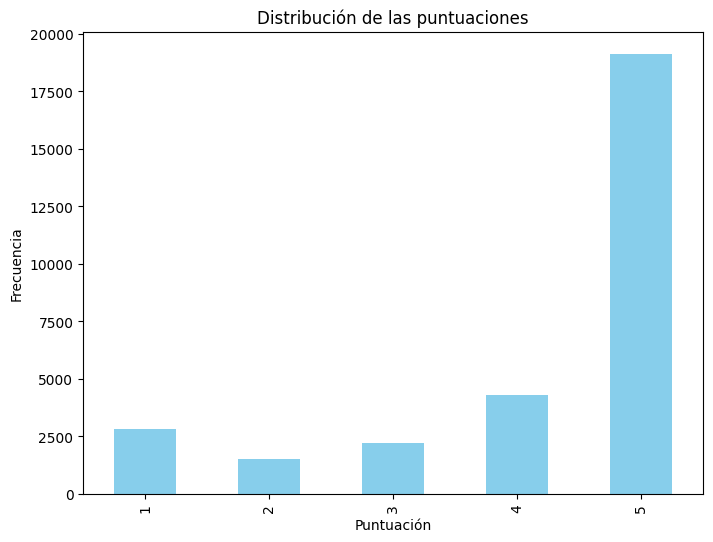

In [8]:
# Distribución de la variable 'Score'
plt.figure(figsize=(8,6))
data['Score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribución de las puntuaciones')
plt.xlabel('Puntuación')
plt.ylabel('Frecuencia')
plt.show()

<div style="background-color: #2e7d6c; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<h2><b>Etapa 2:</b> Preprocesamiento de datos</h2>
</div>

In [9]:
# Filtrar reviews neutras (Score 3)
data = data[data['Score'] != 3].reset_index(drop=True)

# Crear columna de Sentimiento
data['Sentimiento'] = data['Score'].apply(lambda x: 1 if x > 3 else -1)

# Funciones de preprocesamiento
def limpiar_texto(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Eliminar URLs
    text = re.sub(r'<.*?>', '', text)  # Eliminar HTML
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = text.translate(str.maketrans('', '', string.punctuation))  # Eliminar puntuación
    return text

# Aplicar preprocesamiento
data['Text'] = data['Text'].apply(limpiar_texto)

# Tokenización y eliminación de stopwords
# stop_words = set(stopwords.words('english'))
# data['Text'] = data['Text'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stop_words))

data.sample(20)['Text'].values

array(['i purchased the soda stream starter kit  as a fathers day gift for my husband we both enjoy soda water but there are only a few brands weve found which do not taste soapyweve only had it for a week but this little gadget works as advertised it is easy and quick  and effective to use and we all like that we can control the level of fizz  i like more the kids like less i bought extra bottles and flavorings for the kids so everyone could do their own we use it mostly with filtered water although the tap water works perfectly well too as long as you have good tap waterthe flavorings will be used  not as much around here although they seem good and the kids like themi would highly recommend this product the only caveat i would give at this point is make sure you want more gas in your life  my entire family is doing a lot more belching and burping than we ever have before but we like this machine',
       'i was told by the salesman at guitar center that the icicle was easy and very 

In [10]:
contraction_patterns = [
    (r"won't", 'will not'), (r"can't", 'cannot'), (r"i'm", 'i am'), (r"ain't", 'is not'), (r"(\w+)'ll", r'\g<1> will'),
    (r"(\w+)n't", r'\g<1> not'), (r"(\w+)'ve", r'\g<1> have'), (r"(\w+)'s", r'\g<1> is'), (r"(\w+)'re", r'\g<1> are'),
    (r"(\w+)'d", r'\g<1> would'), (r"&", 'and'), (r"dammit", 'damn it'), (r"dont", 'do not'), (r"wont", 'will not')
]

patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]

def replace_contractions(text):
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in word_tokenize(text))

data['clean_text'] = data['Text'].apply(replace_contractions).apply(lemmatize_text)

stop_words = set(stopwords.words('english'))
data['clean_text_no_stopwords'] = data['Text'].apply(replace_contractions).apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stop_words)).apply(lemmatize_text)

data[['clean_text', 'clean_text_no_stopwords', 'Sentimiento']].head(5)

,clean_text,clean_text_no_stopwords,Sentimiento
0,i love this tea it the best earl grey out ther...,love tea best earl grey smell flavor amazing w...,1
1,these are perfict for a night out at the bar w...,perfict night bar friend perfictly dry moistst...,1
2,and he hate everything i fed my cat iams for y...,hate everything fed cat iams year vet reccomen...,1
3,this is great popcorn my two year old daughter...,great popcorn two year old daughter love well ...,1
4,this chai tea is better than any i have had at...,chai tea better coffee shop chill mine ice yum...,1


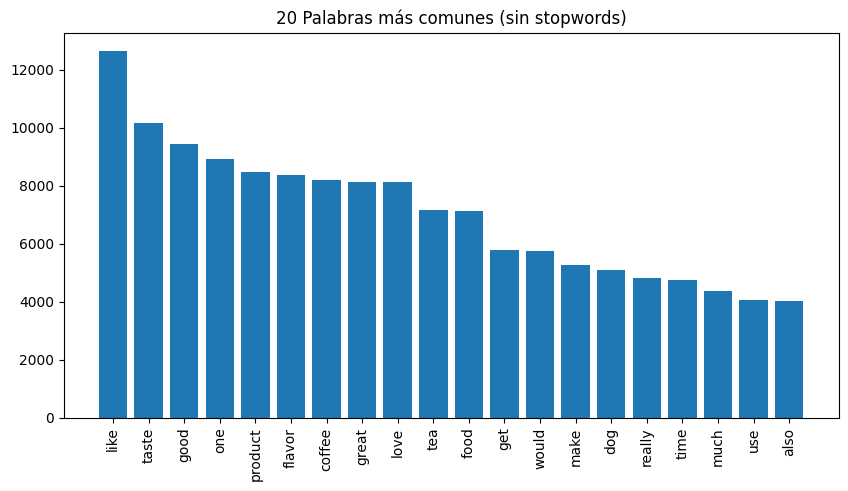

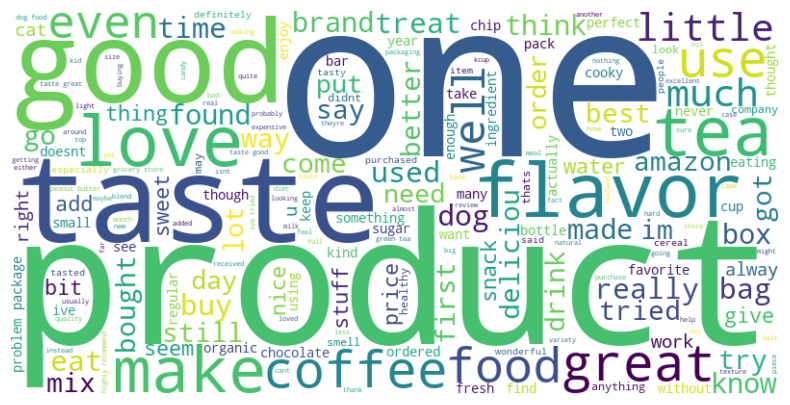

In [11]:
#  Visualización
all_words = ' '.join(data['clean_text_no_stopwords']).split()
word_counts = Counter(all_words)
most_common = pd.DataFrame(word_counts.most_common(20), columns=['word', 'count'])

# Graficar las palabras más comunes
plt.figure(figsize=(10, 5))
plt.bar(most_common['word'], most_common['count'])
plt.xticks(rotation=90)
plt.title('20 Palabras más comunes (sin stopwords)')
plt.show()

def viz_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

stream = ' '.join(data['clean_text_no_stopwords'].to_list())
viz_wordcloud(stream)

<div style="background-color: #2e7d6c; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<h2><b> Etapa 3:</b> Preparación del corpus para entrenamiento (vectorización, división del dataset en train y test)</h2>
</div>

### Generación de embeddings

Para el caso final he optado por utilizar SENTENCE TRANSFORMER

In [12]:
# Función para calcular matriz de similitud de coseno
def cosine_similarity_matrix(features):
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    normalized_features = features / norms
    similarity_matrix = np.inner(normalized_features, normalized_features)
    return np.round(similarity_matrix, 4)

# Visualizar la matriz de similitud con seaborn
def plot_similarity(labels, features, rotation):
    sim = cosine_similarity_matrix(features)
    sns.set_theme(font_scale=1)
    g = sns.heatmap(sim, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    plt.show()
    
def create_embeddings_from_list(data_list, batch_size=64, device="cuda:0"):
    model = SentenceTransformer("all-mpnet-base-v2", device=device)
    return model.encode(
        data_list,
        batch_size=batch_size,
        show_progress_bar=True,
        device=device
    )

In [13]:
sample_reviews_full_context = data['clean_text'].tolist()

# Generar embeddings para todas las reseñas
embeddings = create_embeddings_from_list(sample_reviews_full_context, device=device_name)

Batches: 100%|██████████| 435/435 [01:26<00:00,  5.04it/s]


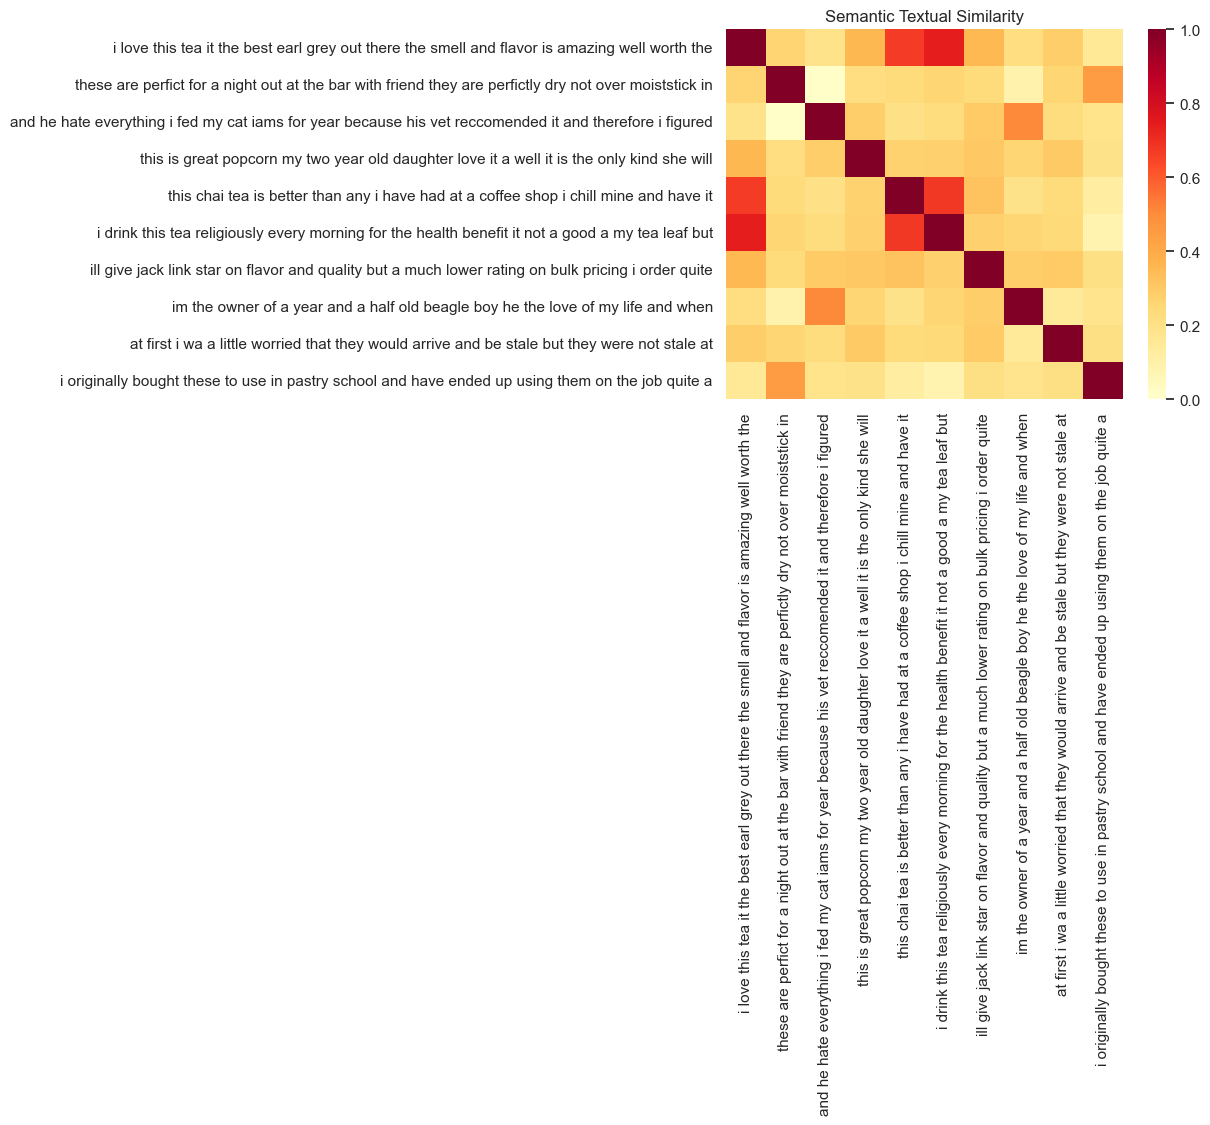

In [14]:
labels_full_context = [' '.join(review.split()[:20]) for review in sample_reviews_full_context]  # hasta 20 palabras solo para mostrar en el gráfico

# Etiquetas de las reseñas para el heatmap
plot_similarity(labels_full_context[:10], embeddings[:10], 90)

### Frecuencias en sentimientos Positivos y negativos

In [15]:
def plot_wordcloud_freq(word_freq, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

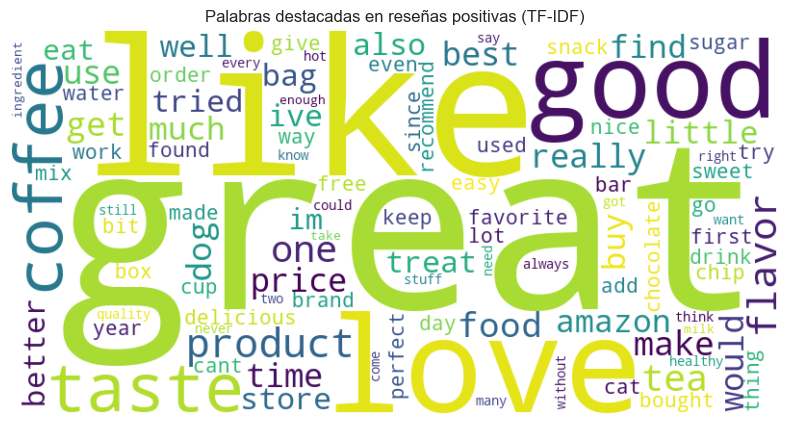

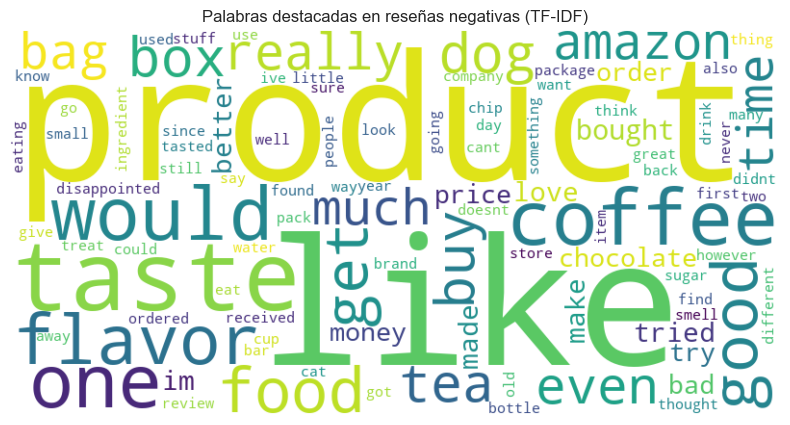

In [16]:
positives = data[data['Sentimiento'] == 1]['clean_text_no_stopwords'].tolist()
negatives = data[data['Sentimiento'] == -1]['clean_text_no_stopwords'].tolist()

tfidf = TfidfVectorizer(max_features=100)

# Palabras destacadas en reseñas positivas
tfidf_pos = tfidf.fit_transform(positives)
tfidf_pos_features = tfidf.get_feature_names_out()
tfidf_pos_scores = tfidf_pos.toarray().sum(axis=0)
top_words_pos = dict(zip(tfidf_pos_features, tfidf_pos_scores))

# Palabras destacadas en reseñas negativas
tfidf_neg = tfidf.fit_transform(negatives)
tfidf_neg_features = tfidf.get_feature_names_out()
tfidf_neg_scores = tfidf_neg.toarray().sum(axis=0)
top_words_neg = dict(zip(tfidf_neg_features, tfidf_neg_scores))

plot_wordcloud_freq(top_words_pos, "Palabras destacadas en reseñas positivas (TF-IDF)")
plot_wordcloud_freq(top_words_neg, "Palabras destacadas en reseñas negativas (TF-IDF)")

### Conjunto de entrenamiento y test

In [17]:
X = embeddings  # Embeddings generados previamente
y = data['Sentimiento'].values  # Variable objetivo

# División inicial del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Verificar la distribución de las clases después del oversampling
print("Distribución de clases antes del SMOTE:")
print(pd.Series(y_train).value_counts())

print("Distribución de clases después del SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Distribución de clases antes del SMOTE:
 1    18750
-1     3472
Name: count, dtype: int64
Distribución de clases después del SMOTE:
 1    18747
-1    18747
Name: count, dtype: int64


<div style="background-color: #2e7d6c; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<h2><b> Etapa 4:</b> Clasificación del dataset (usar al menos dos clasificadores) </h2>
</div>

Clasificador SVM

In [18]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_balanced, y_train_balanced)

SVC(kernel='linear', random_state=42)

Clasificador Red Neuronal con TensorFlow

In [19]:
def f1_metric(y_true, y_pred):
    y_pred = tf.where(y_pred >= 0, 1, -1)  # Convertir las salidas continuas a clases (-1, 1)
    tp = tf.reduce_sum(tf.cast((y_true == 1) & (y_pred == 1), tf.float32))
    fp = tf.reduce_sum(tf.cast((y_true == -1) & (y_pred == 1), tf.float32))
    fn = tf.reduce_sum(tf.cast((y_true == 1) & (y_pred == -1), tf.float32))
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())


model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.1))  # Dropout para evitar overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='tanh'))  # Usamos 'tanh' para que la salida esté entre -1 y 1

# Compilar el modelo
model.compile(optimizer='adam', loss='hinge', metrics=["accuracy", f1_metric])

# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100


c:\Users\usuario\.conda\envs\env_master\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7292 - f1_metric: 0.9091 - loss: 0.4052 - val_accuracy: 0.8452 - val_f1_metric: 0.9158 - val_loss: 0.3096
Epoch 2/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8426 - f1_metric: 0.9139 - loss: 0.3147 - val_accuracy: 0.8452 - val_f1_metric: 0.9158 - val_loss: 0.3095
Epoch 3/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8426 - f1_metric: 0.9138 - loss: 0.3140 - val_accuracy: 0.7978 - val_f1_metric: 0.8666 - val_loss: 0.2322
Epoch 4/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8040 - f1_metric: 0.8640 - loss: 0.2175 - val_accuracy: 0.8079 - val_f1_metric: 0.8553 - val_loss: 0.1672
Epoch 5/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8242 - f1_metric: 0.8659 - loss: 0.1553 - val_accuracy: 0.8090 - val_f1_metric: 0.8533 - val_loss: 0.1554
Epoch 6/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8159 - f1_metric: 0.8540 - loss: 0.1419 - val_accuracy: 0.8083 - val_f1_metric: 

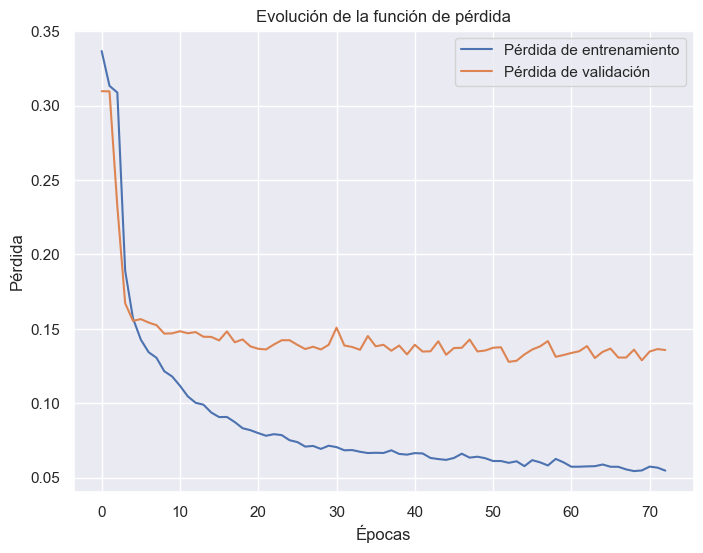

In [20]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la función de pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

<div style="background-color: #2e7d6c; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<h2><b> Etapa 5.a:</b> Evaluación de modelos </h2>
</div>

Evaluación del modelo SVM

Evaluación del modelo SVM:
Accuracy: 0.915946724262059
Reporte de clasificación:
              precision    recall  f1-score   support

          -1       0.69      0.85      0.76       863
           1       0.97      0.93      0.95      4693

    accuracy                           0.92      5556
   macro avg       0.83      0.89      0.85      5556
weighted avg       0.93      0.92      0.92      5556

Matriz de confusión:


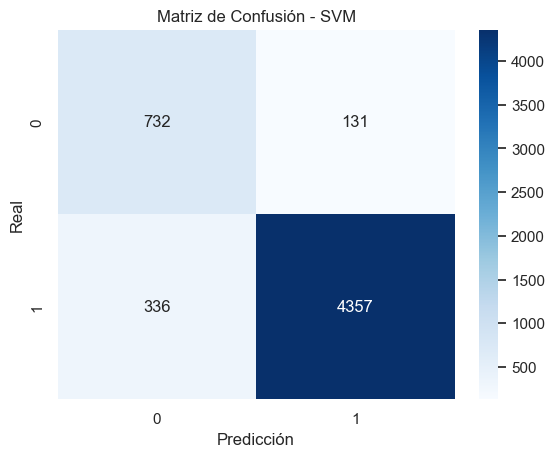

In [21]:
svm_predictions = svm_model.predict(X_test)

print("Evaluación del modelo SVM:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("Reporte de clasificación:")
print(classification_report(y_test, svm_predictions))
print("Matriz de confusión:")
sns.heatmap(confusion_matrix(y_test, svm_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Evaluación del modelo de Red Neuronal

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step

Evaluación del modelo de Red Neuronal con TensorFlow:
Accuracy: 0.9296256299496041
Reporte de clasificación:
              precision    recall  f1-score   support

          -1       0.82      0.70      0.76       863
           1       0.95      0.97      0.96      4693

    accuracy                           0.93      5556
   macro avg       0.88      0.84      0.86      5556
weighted avg       0.93      0.93      0.93      5556

Matriz de confusión:


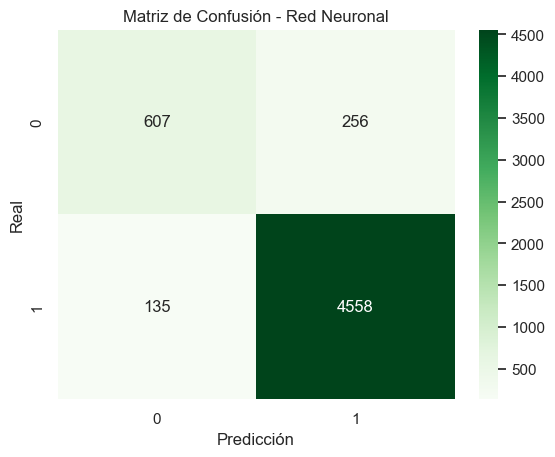

In [22]:
nn_predictions = model.predict(X_test)
nn_predictions = np.where(nn_predictions.flatten() >= 0, 1, -1)

print("\nEvaluación del modelo de Red Neuronal con TensorFlow:")
print("Accuracy:", accuracy_score(y_test, nn_predictions))
print("Reporte de clasificación:")
print(classification_report(y_test, nn_predictions))
print("Matriz de confusión:")
sns.heatmap(confusion_matrix(y_test, nn_predictions), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Red Neuronal')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

<div style="background-color: #2e7d6c; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<h2><b> Etapa 5.b:</b> Discusión y conclusiones </h2>
</div>

1. **Precisión Global**:
   - El modelo basado en redes neuronales tiene una ligera ventaja en precisión general (92.93%) sobre el modelo SVM (91.55%).

2. **Clases Minoritarias**:
   - SVM muestra mejor desempeño en el *recall* (0.85) para la clase minoritaria (-1), capturando más casos relevantes en comparación con la red neuronal (0.70).
   - La red neuronal, sin embargo, tiene una mejor *precision* (0.82) para la misma clase, reduciendo falsos positivos.

3. **Clases Mayoritarias**:
   - Ambas técnicas tienen resultados muy similares en la clase mayoritaria (1), aunque SVM alcanza un *recall* del 0.93 frente al 0.97 de la red neuronal.

4. **Balance entre Clases**:
   - El promedio macro del modelo de redes neuronales es superior al de SVM, mostrando un mejor balance general en las clases.

5. **Matriz de Confusión**:
   - SVM tiene menos falsos negativos en comparación con la red neuronal, lo que es crucial para evitar omitir reviews negativas.
   - La red neuronal tiene menos falsos positivos, favoreciendo un análisis más conservador.

6. **Evolución del Entrenamiento (Red Neuronal)**:
   - La pérdida de entrenamiento disminuye consistentemente, indicando un buen ajuste del modelo.
   - La pérdida de validación se estabiliza tras varias épocas, sin evidencia de sobreajuste significativo.

- **SVM**: Es más adecuado si el objetivo es maximizar la detección de reviews negativas (clase -1).
- **Red Neuronal**: Es preferible si se busca un mejor balance global y minimizar falsos positivos en las predicciones.

- Se podría mejorar el balancea o usar un XGBoost para que no sufra por el desbalanceo de clases